# BGS Signal-to-Noise Ratio and Redshift Efficiency

The goal of this notebook is to assess the signal-to-noise ratio and redshift efficiency of BGS targets observed in "nominal" observing conditions (which are defined [here](https://github.com/desihub/desisurvey/blob/master/py/desisurvey/data/config.yaml#L102) and discussed [here](https://github.com/desihub/desisurvey/issues/77), among other places).  Specifically, the nominal BGS observing conditions we adopt (note the 5-minute exposure time is with the moon down!) are:

```python
{'AIRMASS': 1.0,
 'EXPTIME': 300,
 'SEEING': 1.1,
 'MOONALT': -60,
 'MOONFRAC': 0.0,
 'MOONSEP': 180}
```

During the survey itself, observations with the moon up (i.e., during bright time) will be obtained with longer exposure times according to the bright-time exposure-time model (see [here](https://github.com/desihub/surveysim/tree/master/doc/nb)).

Because we fix the observing conditions, we only consider how redshift efficiency depends on galaxy properties (apparent magnitude, redshift, 4000-A break, etc.).  However, note that the code is structured such that we *could* (now or in the future) explore variations in seeing, exposure time, and lunar parameters.

For code to generate large numbers of spectra over significant patches of sky and to create a representative DESI dataset (with parallelism), see `desitarget/bin/select_mock_targets` and `desitarget.mock.build.targets_truth`.

Finally, note that the various python Classes instantiated here (documented in `desitarget.mock.mockmaker`) are easily extensible to other mock catalogs and galaxy/QSO/stellar physics.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.io import fits

In [ ]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

In [2]:
from desispec.io.util import write_bintable
from desitarget
from desiutil.log import get_logger, DEBUG
log = get_logger()

In [ ]:
if 'HOSTNAME' in os.environ.keys() and os.environ['HOSTNAME'] == 'cori19':
    #import desitarget_fix_densities as desitarget
    from desitarget_fix_densities.cuts import isBGS_bright, isBGS_faint
    from desitarget_fix_densities.mock.mockmaker import BGSMaker
    from desitarget_fix_densities.mock.mockmaker import SKYMaker
    os.environ['DESITARGET'] == os.path.join(os.curdir,'desitarget_fix_densities')
else:
    from desitarget.cuts import isBGS_bright, isBGS_faint
    from desitarget.mock.mockmaker import BGSMaker
    from desitarget.mock.mockmaker import SKYMaker

In [3]:
import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='deep')

In [4]:
%matplotlib inline

#### Establish the I/O path, random seed, and path to the dust maps and desired healpixel.

In [5]:
simdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'sim', 'bgs')
dust_dir = '/Users/ioannis/research/data/sfd_dustmaps/maps'

In [6]:
healpixel = 26030
nside = 64

In [7]:
seed = 555
rand = np.random.RandomState(seed)

### All or none of the output files can be overwritten using these keywords.

In [ ]:
overwrite_spectra = False
overwrite_redshifts = False
overwrite_results = False

## Set up the simulation parameters.

Here we use the mock to capture the correct distribution of apparent magnitudes, galaxy properties, and redshifts.

Note that if `use_mock=False` then *rmagmin*, *rmagmax*, *zmin*, and *zmax* are required. For example, here's another possible simulation of 1000 spectra in which the magnitude (r=19.5) and redshift (z=0.2) are held fixed while moonfrac and moonsep are varied (as well as intrinsic galaxy properties):

```python
sim2 = dict(suffix='sim02',
            use_mock=False,
            nsim=10,
            nspec=100,
            seed=22,
            zmin=0.2, zmax=0.2,
            rmagmin=19.5, rmagmax=19.5,
            moonfracmin=0.0, moonfracmax=1.0,
            moonsepmin=0.0, moonsepmax=120.0,
           )
```

In [ ]:
# Vary galaxy properties with nominal observing conditions but split 
# the sample into nsim chunks to avoid memory issues.
sim1 = dict(suffix='sim01',
            use_mock=True,
            nsim=10,
            nspec=100,
            seed=11,
           )

In [ ]:
#from desisim.simexp import reference_conditions
#ref_obsconditions = reference_conditions['BGS']
ref_obsconditions = {'AIRMASS': 1.0, 'EXPTIME': 300, 'SEEING': 1.1, 'MOONALT': -60, 'MOONFRAC': 0.0, 'MOONSEP': 180}
print(ref_obsconditions)

### Generate Spectra

In [ ]:
from desistudy import bgs_sim_spectra

for sim in np.atleast_1d(sim1):
    bgs_sim_spectra(sim, verbose=False, overwrite=overwrite_spectra)

## Fit the redshifts.

This step took ~1.8 seconds per spectrum, ~3 minutes per 100 spectra, or ~30 minutes for all 1000 spectra with my 4-core laptop.

In [ ]:
from desistudy import bgs_redshifts

for sim in np.atleast_1d(sim1):
    bgs_redshifts(sim, overwrite=overwrite_redshifts)

## Gather the results.

In [ ]:
from desistudy import bgs_gather_results

for sim in np.atleast_1d(sim1):
    bgs_gather_results(sim, overwrite=overwrite_results)

## Analyze the outputs.

We only have one simulation so the code below is hard-coded to sim1, although it would be trivial to generalize.

In [ ]:
sim = sim1
resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
log.info('Reading {}'.format(resultfile))
result = Table.read(resultfile)
result

In [ ]:
from desistudy import qa_zmag, qa_efficiency, qa_zwarn4, qa_radec

In [ ]:
qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)

In [ ]:
qa_efficiency(result)

In [ ]:
qa_zwarn4(result)

#### BGS
** NOTE ** must be in branch 'fix-densities' of desitarget for the mocktarget things


data is a dictionary of lists:
    data = {'TARGET_NAME': target_name_list, 'MOCKFORMAT': 'gaussianfield',
               'OBJID': objid_list, 'MOCKID': mockid_list, 'BRICKNAME': brickname_list,
               'RA': ra_list, 'DEC': dec_list, 'Z': zz_list,'FILES': files_list, 'N_PER_FILE': n_per_file}


but data has to be run through:

  _prepare_spectra(data, nside_chunk=128):
  
  which adds the following to data with appropriate defaults
  
        data.update({
            'TRUESPECTYPE': 'GALAXY', 'TEMPLATETYPE': 'BGS', 'TEMPLATESUBTYPE': '',
            'SEED': seed, 'VDISP': vdisp, 
            'SHAPEEXP_R': gmm['exp_r'], 'SHAPEEXP_E1': gmm['exp_e1'], 'SHAPEEXP_E2': gmm['exp_e2'], 
            'SHAPEDEV_R': gmm['dev_r'], 'SHAPEDEV_E1': gmm['dev_e1'], 'SHAPEDEV_E2': gmm['dev_e2'],
            })

indx is an optional list of inde=indices to use corresponding to the indices of the above list

Once data (and optionally indx) are defined we're ready to make the spectra;

    bgsmaker.make_spectra(self, data=data, indx=None) 


make_spectra returns:

        Returns
        -------
        flux : :class:`numpy.ndarray`
            Target spectra.
        wave : :class:`numpy.ndarray`
            Corresponding wavelength array.
        meta : :class:`astropy.table.Table`
            Spectral metadata table.
        targets : :class:`astropy.table.Table`
            Target catalog.
        truth : :class:`astropy.table.Table`
            Corresponding truth table.

INFO:io.py:962:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/bgs_templates_v2.1.fits metadata.
INFO:<ipython-input-9-288e41354821>:5:demo_mockmaker: Reading the mock catalog for BGSs
INFO:mockmaker.py:1030:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:1040:readmock: Trimmed to 2338 BGSs in healpixels 26030
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/bgs_templates_v2.1.fits
INFO:<ipython-input-9-288e41354821>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-9-288e41354821>:12:demo_mockmaker: Selecting targets
CPU times: user 14.7 s, sys: 2.63 s, total: 17.3 s
Wall time: 16.9 s


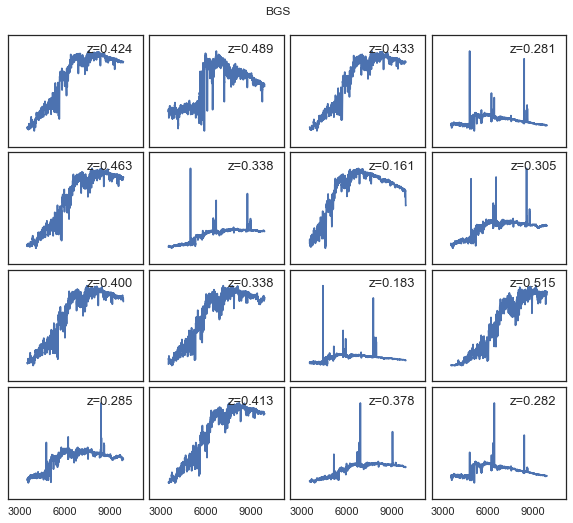

In [32]:
#bgsmaker = BGSMaker(seed=seed)

#log.info('Reading the mock catalog for {}s'.format(bgsmaker.objtype))

#data = {'TARGET_NAME': target_name_list, 'MOCKFORMAT': 'gaussianfield',
#               'OBJID': objid_list, 'MOCKID': mockid_list, 'BRICKNAME': brickname_list,
#               'RA': ra_list, 'DEC': dec_list, 'Z': zz_list,'FILES': files_list, 'N_PER_FILE': n_per_file}

## If you want to start from an existing default dictionary, you could use:
##    tdata = bgsmaker.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)
## then either overwrite the relevant details (e.g. z, mag, ra, dec, ids) 
## or actually use the defaults for your analysis

## but first we have to prepare the spectra. this internal function adds required fields 
## to the data dictionary that we don't want to deal with ourselves
#data = bgsmaker._prepare_spectra(data, nside_chunk=nside_chunk)

## Finally we can make the spectra
#flux, wave, meta, targets, truth = bgsmaker.make_spectra(data) 

In [ ]:
from desistudy import write_templates
write_templates(outfile, flux, wave, meta)

In [ ]:
from desisim.scripts.quickspectra import sim_spectra

In [ ]:
simdata = bgs_write_simdata(sim,rand,overwrite=overwrite_spectra)

for ii, simdata1 in enumerate(simdata):

    # Generate the observing conditions dictionary.  
    obs = simdata2obsconditions(simdata1)

    # Generate the rest-frame templates.  Currently not writing out the rest-frame 
    # templates but we could.
    flux, wave, meta = bgs_make_templates(sim, rand, BGSmaker)

    truefile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}-true.fits'.format(sim['suffix'], ii))
    if overwrite or not os.path.isfile(truefile):    
        write_templates(truefile, flux, wave, meta)

    spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
    if overwrite or not os.path.isfile(spectrafile):
        sim_spectra(wave, flux, 'bgs', spectrafile, obsconditions=obs, 
                    sourcetype='bgs', seed=sim['seed'], expid=ii)
    else:
        print('File {} exists...skipping.'.format(spectrafile))

### Finally demonstrate how to generate (empyt) SKY spectra.

In [41]:
#SKY = SKYMaker(seed=seed)
#skydata = SKY.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)
#skyflux, skywave, skymeta, skytargets, skytruth = SKY.make_spectra(skydata)
#SKY.select_targets(skytargets, skytruth)

INFO:mockmaker.py:583:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.1/2048/random.fits
INFO:mockmaker.py:595:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:604:readmock: Trimmed to 1659 SKYs in healpixel(s) 26030
